In [148]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

path = "HWD48/"
train_data = pd.read_csv(path + 'train.csv', header=None)
train_labels = pd.read_csv(path + 'trainLabels.csv', header=None)
test_data = pd.read_csv(path + 'test.csv', header=None)

x_train = np.asarray(train_data)
y_train = np.asarray(train_labels).ravel()
x_test= np.asarray(test_data)

df = pd.concat([train_data, test_data])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.299403,-1.226624,1.498425,-1.176150,5.289853,0.208297,2.404498,1.594506,-0.051608,0.663234,...,-0.850465,-0.622990,-1.833057,0.293024,3.552681,0.717611,3.305972,-2.715559,-2.682409,0.101050
1,-1.174176,0.332157,0.949919,-1.285328,2.199061,-0.151268,-0.427039,2.619246,-0.765884,-0.093780,...,-0.819750,0.012037,2.038836,0.468579,-0.517657,0.422326,0.803699,1.213219,1.382932,-1.817761
2,1.192222,-0.414371,0.067054,-2.233568,3.658881,0.089007,0.203439,-4.219054,-1.184919,-1.240310,...,-0.604501,0.750054,-3.360521,0.856988,-2.751451,-1.582735,1.672246,0.656438,-0.932473,2.987436
3,1.573270,-0.580318,-0.866332,-0.603812,3.125716,0.870321,-0.161992,4.499666,1.038741,-1.092716,...,1.022959,1.275598,-3.480110,-1.065252,2.153133,1.563539,2.767117,0.215748,0.619645,1.883397
4,-0.613071,-0.644204,1.112558,-0.032397,3.490142,-0.011935,1.443521,-4.290282,-1.761308,0.807652,...,0.513906,-1.803473,0.518579,-0.205029,-4.744566,-1.520015,1.830651,0.870772,-1.894609,0.408332


In [149]:
#顯示nan的資料
df1 = df[df.isna().any(axis=1)]
print(df1)

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Index: []

[0 rows x 40 columns]


In [150]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,GridSearchCV
from mlxtend.classifier import StackingClassifier

#### LogisticRegression 

In [151]:
lgr = LogisticRegression(class_weight="balanced",n_jobs=-1)
##lgr.fit(x_train, y_train)
##y_pred = lgr.predict(x_test)
scores = cross_val_score(lgr, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

0.8220000000000001 0.79
[0.84 0.86 0.82 0.79 0.8 ]


In [152]:
# 建立要調整的超參數
solver = ['liblinear','sag','saga']
max_iter = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
random_grid = {'solver': solver,
               'max_iter': max_iter}


In [153]:
## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(lgr, random_grid, scoring="accuracy", n_jobs=-1, verbose=1,cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


In [154]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.822000 using {'solver': 'saga', 'max_iter': 1577}


In [155]:
lgr = LogisticRegression(class_weight="balanced",n_jobs=-1,solver=grid_result.best_params_['solver'],
                        max_iter=grid_result.best_params_['max_iter'])
scores = cross_val_score(lgr, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)
lgr.fit(x_train, y_train)
y_pred = lgr.predict(x_test)
report = pd.DataFrame({'ID': np.arange(1, len(x_test)+1), 'Solution': y_pred})
report.to_csv('HWD48/lgr.csv', index=False)

0.8220000000000001 0.79
[0.84 0.86 0.82 0.79 0.8 ]


In [156]:
#### DecisionTree

In [157]:
dtree = DecisionTreeClassifier()
scores = cross_val_score(dtree, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

0.757 0.705
[0.705 0.83  0.76  0.725 0.765]


In [158]:
# 建立要調整的超參數
criterion = ['gini','entropy']
random_grid = {'criterion': criterion}

In [159]:
## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(dtree, random_grid, scoring="accuracy", n_jobs=-1, verbose=1,cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [160]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.784000 using {'criterion': 'entropy'}


In [161]:
dtree = DecisionTreeClassifier(criterion=grid_result.best_params_['criterion'], max_depth=None
                               , min_samples_split=2, min_samples_leaf=1)
scores = cross_val_score(dtree, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
report = pd.DataFrame({'ID': np.arange(1, len(x_test)+1), 'Solution': y_pred})
report.to_csv('HWD48/dtree.csv', index=False)

0.787 0.755
[0.775 0.85  0.79  0.765 0.755]


#### RandomForest

In [162]:
rdf = RandomForestClassifier(n_estimators=100,max_depth=5,criterion='gini')
scores = cross_val_score(rdf, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

0.842 0.825
[0.845 0.86  0.845 0.835 0.825]


In [163]:
# 建立要調整的超參數
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
max_depth = [int(x) for x in np.linspace(3, 110, num = 21)]
criterion = ['gini','entropy']
max_features = ['auto','sqrt','log2']
random_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'criterion': criterion,
               'max_features':max_features}

In [164]:
## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(rdf, random_grid, scoring="accuracy", n_jobs=-1, verbose=1,cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


In [165]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.877000 using {'n_estimators': 1240, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'entropy'}


In [166]:
rdf = RandomForestClassifier(criterion=grid_result.best_params_['criterion'],max_features=grid_result.best_params_['max_features']
                            ,n_estimators=grid_result.best_params_['n_estimators'],max_depth=grid_result.best_params_['max_depth'])
scores = cross_val_score(rdf, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)
rdf.fit(x_train, y_train)
y_pred = rdf.predict(x_test)
report = pd.DataFrame({'ID': np.arange(1, len(x_test)+1), 'Solution': y_pred})
report.to_csv('HWD48/rdf.csv', index=False)

0.8709999999999999 0.845
[0.885 0.885 0.875 0.865 0.845]


In [167]:
#### GradientBoosting

In [168]:
gdb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5)
scores = cross_val_score(gdb, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

0.875 0.86
[0.88  0.9   0.87  0.86  0.865]


In [169]:
# 建立要調整的超參數
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
max_depth = [int(x) for x in np.linspace(3, 110, num = 21)]
learning_rate = [1,0.5,0.2,0.1,0.05,0.01]
subsample = [1.0,0.5,0.6,0.7,0.8]
random_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'learning_rate':learning_rate,
               'subsample': subsample}

In [170]:
## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(gdb, random_grid, scoring="accuracy", n_jobs=-1, verbose=1,cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


In [171]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.890000 using {'subsample': 0.8, 'n_estimators': 860, 'max_depth': 61, 'learning_rate': 0.01}


In [172]:
gdb = GradientBoostingClassifier(n_estimators=grid_result.best_params_['n_estimators'],max_depth=grid_result.best_params_['max_depth']
                                ,learning_rate=grid_result.best_params_['learning_rate'],subsample=grid_result.best_params_['subsample'])
scores = cross_val_score(gdb, x_train, y_train,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)
gdb.fit(x_train, y_train)
y_pred = gdb.predict(x_test)
report = pd.DataFrame({'ID': np.arange(1, len(x_test)+1), 'Solution': y_pred})
report.to_csv('HWD48/gdb.csv', index=False)

0.889 0.865
[0.89  0.915 0.9   0.875 0.865]


In [173]:
gdb = GradientBoostingClassifier(n_estimators=grid_result.best_params_['n_estimators'],max_depth=grid_result.best_params_['max_depth']
                                ,learning_rate=grid_result.best_params_['learning_rate'],subsample=grid_result.best_params_['subsample'])
sclf = StackingClassifier(classifiers=[lgr, dtree, rdf], 
                          meta_classifier=gdb,use_probas=True, average_probas=False)

sclf.fit(x_train, y_train)
y_pred = sclf.predict(x_test)
report = pd.DataFrame({'ID': np.arange(1, len(x_test)+1), 'Solution': y_pred})
report.to_csv('HWD48/sclf.csv', index=False)

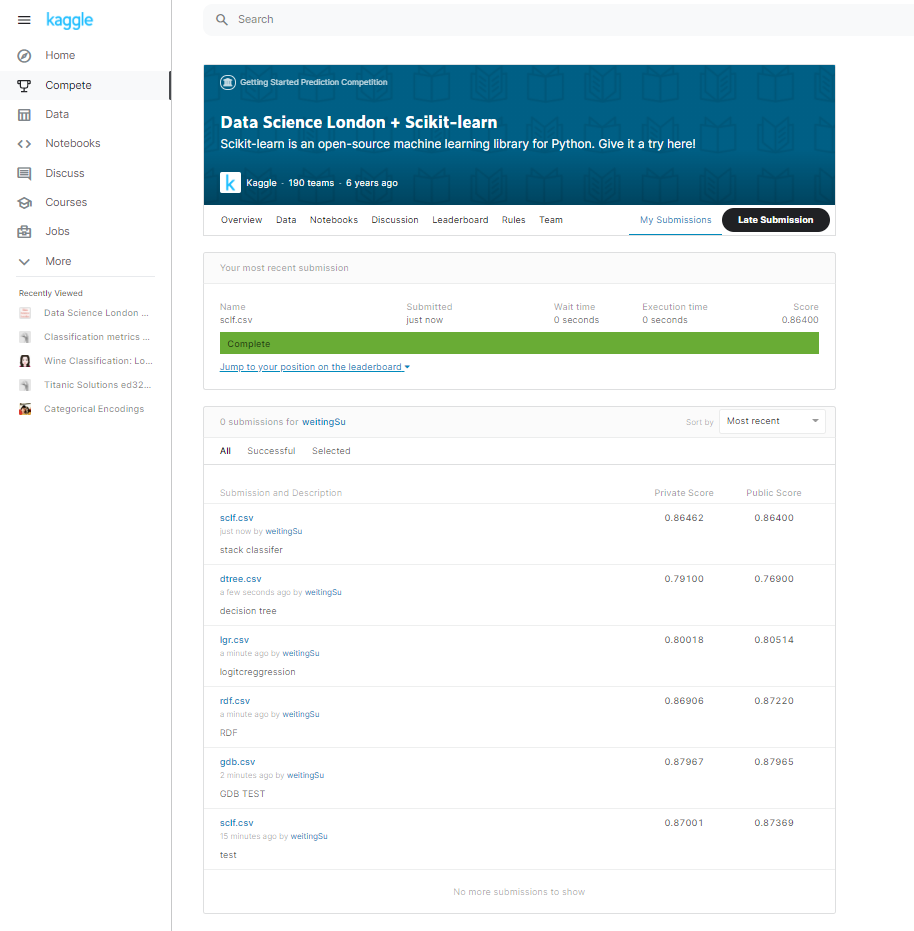

In [174]:
from IPython.display import Image
Image("HWD48/kaggleHW48.png")